In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device = "cpu"

In [16]:
rng = "Sobol"
# rng = "Race"

in_feature = 128
out_feature = 10000

mode = "bipolar"
scaled = False
bias =   True

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)

if mode is "unipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(256).round().div(256).to(device)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(256).round().div(256).to(device)
elif mode is "bipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(256).round().div(256).to(device)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(256).round().div(256).to(device)

ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, mode=mode, scaled=scaled, bias=bias).to(device)

iVec = ((torch.rand(1, in_feature)*256).round()/256).to(device)
oVec = fc(iVec)

if scaled is False:
    oVec = oVec.clamp(-1.,1.).mul(256).floor()/256
else:
    if bias is True:
        oVec = oVec.div(in_feature+1).mul(256).floor()/256
    else:
        oVec = oVec.div(in_feature).mul(256).floor()/256

        
iVecSource = SourceGen(iVec, bitwidth=8, mode=mode)().to(device)

iVecRNG = RNG(8, 1, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    time 
    start_time = time.time()
    for i in range(256):
#         print(i)
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)
        
        oVecU = ufc(iBS)
        oVecPE.Monitor(oVecU)
#         print("\n")
    print("--- %s seconds ---" % (time.time() - start_time))
    print("input error: ", min(min(iVecPE()[1])), max(max(iVecPE()[1])))
    print("output error:", min(min(oVecPE()[1])), max(max(oVecPE()[1])))
    print("output pp:", oVecPE()[0].data)
    result_pe = oVecPE()[1][0].cpu().numpy()
    print(torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature))
    print(result_pe)

--- 0.45610833168029785 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error: tensor(-0.5039, device='cuda:0') tensor(0.1016, device='cuda:0')
output pp: tensor([[ 0.9609, -1.0000,  0.9844,  ...,  0.9922, -0.9375,  0.9844]],
       device='cuda:0')
tensor(0.1353, device='cuda:0')
[-0.0390625  0.        -0.015625  ... -0.0078125  0.0625    -0.015625 ]


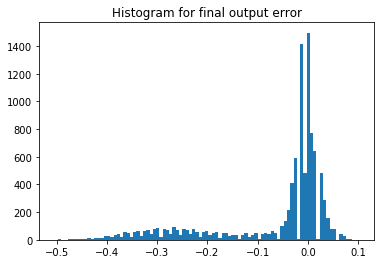

In [17]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [217]:
# passed test
# 1. unipolar,     scaled,     biased: passed
# 2. unipolar,     scaled, non-biased: passed
# 3. unipolar, non-scaled,     biased: passed
# 4. unipolar, non-scaled, non-biased: passed
# 5.  bipolar,     scaled,     biased: passed
# 6.  bipolar,     scaled, non-biased: passed
# 7.  bipolar, non-scaled,     biased: passed
# 8.  bipolar, non-scaled, non-biased: passed

In [30]:
a = torch.tensor([0.])

In [31]:
for i in range(20):
    print(a>>1)
    print(a)
    print(a.fill_(i).log2())
    print()

tensor([0.])
tensor([0.])
tensor([-inf])

tensor([0.])
tensor([0.])
tensor([0.])

tensor([0.5000])
tensor([1.])
tensor([1.])

tensor([1.])
tensor([2.])
tensor([1.5850])

tensor([1.5000])
tensor([3.])
tensor([2.])

tensor([2.])
tensor([4.])
tensor([2.3219])

tensor([2.5000])
tensor([5.])
tensor([2.5850])

tensor([3.])
tensor([6.])
tensor([2.8074])

tensor([3.5000])
tensor([7.])
tensor([3.])

tensor([4.])
tensor([8.])
tensor([3.1699])

tensor([4.5000])
tensor([9.])
tensor([3.3219])

tensor([5.])
tensor([10.])
tensor([3.4594])

tensor([5.5000])
tensor([11.])
tensor([3.5850])

tensor([6.])
tensor([12.])
tensor([3.7004])

tensor([6.5000])
tensor([13.])
tensor([3.8074])

tensor([7.])
tensor([14.])
tensor([3.9069])

tensor([7.5000])
tensor([15.])
tensor([4.])

tensor([8.])
tensor([16.])
tensor([4.0875])

tensor([8.5000])
tensor([17.])
tensor([4.1699])

tensor([9.])
tensor([18.])
tensor([4.2479])



In [44]:
a.fill_(2)
print(a.log2())

tensor([1.])


In [45]:
a.fill_(2.5)
print(a.log2())

tensor([1.3219])


In [46]:
a.fill_(2.5)
print(a<<1)
print((a<<1).log2()-torch.tensor([2.]).log2())

tensor([5.])
tensor([1.3219])
